# Activity Prediction

#### Thirty volunteers engaged in 12 different physical activities. They were wearing a smartphone, which captured movement data via the embedded accelerometer and gyroscope. Below, a subset of the collected data was used to attempt to classify what movement the volunteers made. A random forest classifier was the tool of choice, as there were a large number of variables.

#### A more thorough description of the experiment and dataset can be found here:
http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions

In [1]:
%matplotlib inline
import pandas as pd
from sklearn import cross_validation as cv
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#### Read in the data for the training table, filtered for 'Mag' and 'Angle' variables, and add 'subject' and 'activity' columns.

In [2]:
features = [line.strip() for line in open('HAPT_Data_Set/features.txt','r')]
sub_features = [(features.index(s), s) for s in features if ('Mag' in s) or ('Angle' in s)]
sub_features_indices = [i[0] for i in sub_features]
sub_features_names = [i[1] for i in sub_features]
df = pd.read_table('HAPT_Data_Set/Train/X_train.txt', delimiter=' ',
                       usecols=sub_features_indices, names=sub_features_names)
subjects = [line.strip() for line in open('HAPT_Data_Set/Train/subject_id_train.txt','r')]
df['subject'] = subjects
activity = [line.strip() for line in open('HAPT_Data_Set/Train/y_train.txt','r')]
df['activity'] = activity
df.head()

,tBodyAccMag-Mean-1,tBodyAccMag-STD-1,tBodyAccMag-Mad-1,tBodyAccMag-Max-1,tBodyAccMag-Min-1,tBodyAccMag-SMA-1,tBodyAccMag-Energy-1,tBodyAccMag-IQR-1,tBodyAccMag-ropy-1,tBodyAccMag-ARCoeff-1,...,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,subject,activity
0,-0.969546,-0.961540,-0.967646,-0.947236,-0.994174,-0.969546,-0.999150,-0.970525,-0.219620,-0.124072,...,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718,1,5
1,-0.984484,-0.981042,-0.983105,-0.979658,-0.996348,-0.984484,-0.999709,-0.986893,-0.426713,0.129618,...,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436,1,5
2,-0.987805,-0.990189,-0.990798,-0.987446,-0.996348,-0.987805,-0.999818,-0.990025,-0.583114,0.086279,...,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271,1,5
3,-0.989940,-0.988966,-0.989351,-0.987446,-0.997687,-0.989940,-0.999849,-0.988460,-0.572296,-0.044082,...,-0.491604,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826,1,5
4,-0.994669,-0.992678,-0.992968,-0.991914,-0.997687,-0.994669,-0.999929,-0.992688,-0.686673,0.228080,...,-0.702490,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080,1,5


#### Follow the same process for the testing table.

In [3]:
df_test = pd.read_table('HAPT_Data_Set/Test/X_test.txt', delimiter=' ',
                       usecols=sub_features_indices, names=sub_features_names)
subjects_test = [line.strip() for line in open('HAPT_Data_Set/Test/subject_id_test.txt','r')]
df_test['subject'] = subjects_test
activity_test = [line.strip() for line in open('HAPT_Data_Set/Test/y_test.txt','r')]
df_test['activity'] = activity_test

#### Plot body acceleration magnitude histograms for the 12 activities to evaluate the ability of this particular variable to predict static vs dynamic activities.

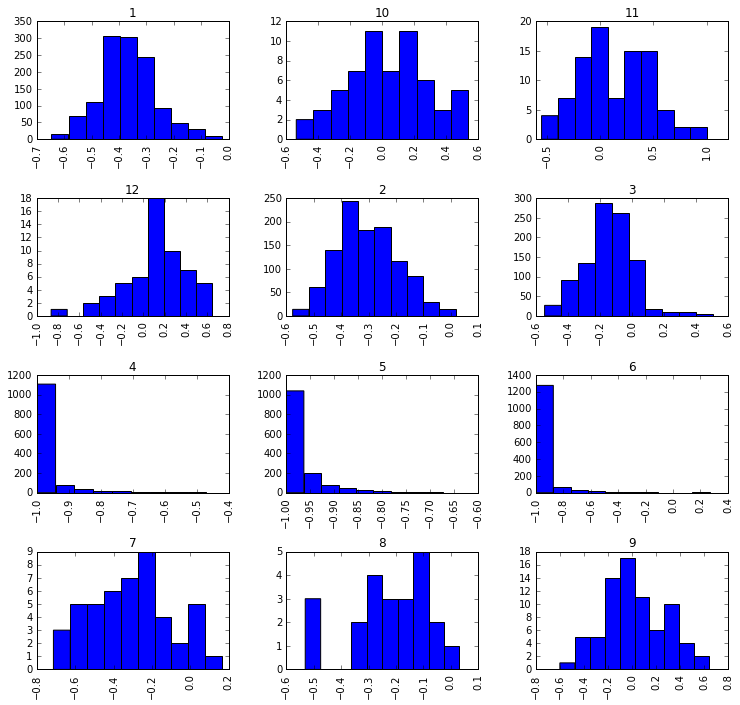

In [4]:
df['tBodyAccMag-Mean-1'].hist(by=df['activity'],figsize=(12,12));

#### Split the initial training table into training and validation sets, and fit a random forest classifier to the training set.

In [5]:
X = df[df.columns.tolist()[:-1]]
y = df['activity']

X_train, X_val, y_train, y_val = cv.train_test_split(X, y, train_size=0.8, random_state=0)
clf = RandomForestClassifier(n_estimators=500, oob_score=True)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

#### Rank the features by importance scores, and single out the top 10 features.

In [6]:
importance_scores = clf.feature_importances_.tolist()
important_features = list(zip(df.columns.tolist()[:-1], importance_scores))
important_features.sort(key=lambda x: x[1], reverse=True)
top_10_features = important_features[:10]
top_10_features

[('tXAxisAcc-AngleWRTGravity-1', 0.1202570917279204),
 ('tYAxisAcc-AngleWRTGravity-1', 0.10219373443557674),
 ('tZAxisAcc-AngleWRTGravity-1', 0.058339538501127344),
 ('tBodyAccJerkMag-ropy-1', 0.020613954207246373),
 ('tBodyAccJerkMag-Energy-1', 0.020311065725199372),
 ('tBodyAccJerkMag-SMA-1', 0.020185554237886736),
 ('tBodyAccJerkMag-Mean-1', 0.01856971240664001),
 ('tBodyAccJerkMag-IQR-1', 0.017638799632304348),
 ('tBodyGyroJerkMag-Mean-1', 0.017357349973420613),
 ('tBodyAccMag-ARCoeff-1', 0.015605708367916013)]

#### Identify the model's accuracy score on the validation set, and then the accuracy, precision, recall, F1, and OOB scores on the test set. Print out a confusion matrix on the test set as well.

In [7]:
predicted_from_val = clf.predict(X_val)
expected_from_val = y_val

metrics.accuracy_score(expected_from_val, predicted_from_val)

0.94658944658944655

In [8]:
predicted_from_test = clf.predict(df_test[df_test.columns.tolist()[:-1]])
expected_from_test = df_test['activity']

metrics.accuracy_score(expected_from_test, predicted_from_test)

0.8801391524351676

In [9]:
metrics.precision_score(expected_from_test, predicted_from_test, average=None)

array([ 0.83047945,  0.62068966,  0.6097561 ,  0.58333333,  0.82463466,
        0.95652174,  0.9044586 ,  0.86363636,  1.        ,  0.61111111,
        0.75      ,  0.62162162])

In [10]:
metrics.recall_score(expected_from_test, predicted_from_test, average=None)

array([ 0.97782258,  0.72      ,  0.51020408,  0.25925926,  0.83864119,
        0.78571429,  0.83858268,  0.92266187,  0.99816514,  0.47826087,
        0.6       ,  0.71875   ])

In [11]:
metrics.f1_score(expected_from_test, predicted_from_test, average=None)

array([ 0.89814815,  0.66666667,  0.55555556,  0.35897436,  0.83157895,
        0.8627451 ,  0.87027579,  0.89217391,  0.99908173,  0.53658537,
        0.66666667,  0.66666667])

In [12]:
clf.oob_score_

0.94012554321583774

In [13]:
metrics.confusion_matrix(expected_from_test, predicted_from_test)

array([[485,   0,   0,   0,   4,   7,   0,   0,   0,   0,   0,   0],
       [  0,  18,   1,   5,   1,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0,  25,   0,   6,   1,   1,   0,   0,   3,   0,  11],
       [  1,  11,   5,   7,   1,   0,   0,   0,   0,   0,   0,   2],
       [ 69,   0,   0,   0, 395,   7,   0,   0,   0,   0,   0,   0],
       [ 27,   0,   0,   0,  63, 330,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 426,  81,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,  42, 513,   0,   1,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0, 544,   0,   0,   0],
       [  0,   0,   3,   0,   6,   0,   1,   0,   0,  11,   2,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0,   0,   2,   6,   1],
       [  0,   0,   7,   0,   2,   0,   0,   0,   0,   0,   0,  23]])